# GAN and WGAN for Minority Class Data Generation

This notebook focuses on:
- Filtering data for the minority class (class = 1)
- Training Vanilla GAN and WGAN on that filtered data
- Generating synthetic samples for the minority class


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install torch torchvision matplotlib pandas scikit-learn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pwd

/content


In [3]:
# Load dataset
df = pd.read_csv('drive/MyDrive/training/ScaniaDataset/pca_aps_mean_failure_train_set.csv')

# Assume last column is label
features = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values

# Filter only minority class (class = 1)
minority_features = features[labels == 1]

# Normalize
# scaler = MinMaxScaler(feature_range=(-1, 1))
# minority_scaled = scaler.fit_transform(minority_features)
# minority_tensor = torch.tensor(minority_scaled, dtype=torch.float32)

minority_tensor = torch.tensor(minority_features, dtype=torch.float32)
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
input_dim = minority_tensor.shape[1]

dataset = TensorDataset(minority_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [5]:
df.head()

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,class
0,-0.357653,0.149168,0.785559,0.107379,0.068720,-0.028512,0.128307,0.002902,0.073669,0.079233,-0.019663,0
1,-0.009868,0.178451,-0.153641,-0.106095,-0.115751,0.677376,0.038713,0.021226,-0.052543,-0.016909,-0.012898,0
2,0.036263,-0.202770,-0.164386,-0.072079,-0.131766,-0.043973,-0.051563,-0.000143,-0.000497,-0.034116,-0.000904,0
3,0.207965,-0.419020,-0.145090,-0.048601,0.000098,-0.007554,-0.008067,0.004260,-0.006622,0.011792,-0.001259,0
4,-0.111736,0.259781,-0.174570,-0.061653,0.000418,-0.020208,0.079826,-0.010607,-0.004089,-0.047178,-0.014056,0


In [11]:
df['class'].unique()

array([0, 1])

In [15]:
minority_tensor.shape[-1]
dataset[0]

(tensor([-0.4396,  0.7052, -0.2081, -0.1355,  0.0389,  0.0032,  0.1428, -0.0251,
         -0.0919,  0.1216,  0.0028]),)

In [16]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, 0.0, 0.02)


In [17]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


## Train GAN on Minority Class

[GAN] Epoch 1 | D Loss: 1.3898 | G Loss: 0.6748
[GAN] Epoch 2 | D Loss: 1.3867 | G Loss: 0.6824
[GAN] Epoch 3 | D Loss: 1.3828 | G Loss: 0.6895
[GAN] Epoch 4 | D Loss: 1.3804 | G Loss: 0.6963
[GAN] Epoch 5 | D Loss: 1.3778 | G Loss: 0.7032


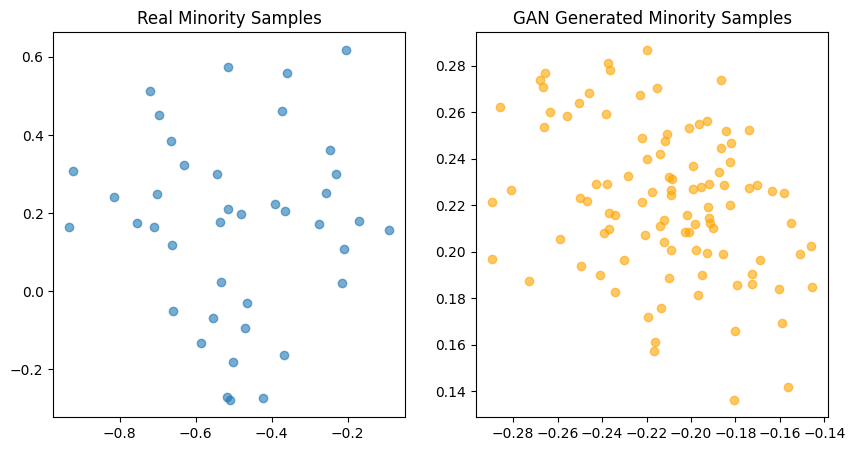

[GAN] Epoch 6 | D Loss: 1.3763 | G Loss: 0.7097
[GAN] Epoch 7 | D Loss: 1.3720 | G Loss: 0.7162
[GAN] Epoch 8 | D Loss: 1.3719 | G Loss: 0.7224
[GAN] Epoch 9 | D Loss: 1.3721 | G Loss: 0.7281
[GAN] Epoch 10 | D Loss: 1.3703 | G Loss: 0.7333


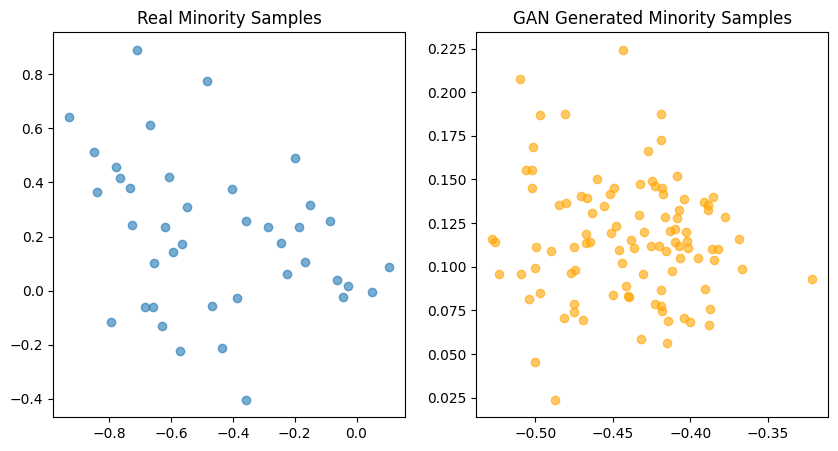

[GAN] Epoch 11 | D Loss: 1.3711 | G Loss: 0.7381
[GAN] Epoch 12 | D Loss: 1.3665 | G Loss: 0.7433
[GAN] Epoch 13 | D Loss: 1.3677 | G Loss: 0.7470
[GAN] Epoch 14 | D Loss: 1.3685 | G Loss: 0.7515
[GAN] Epoch 15 | D Loss: 1.3689 | G Loss: 0.7556


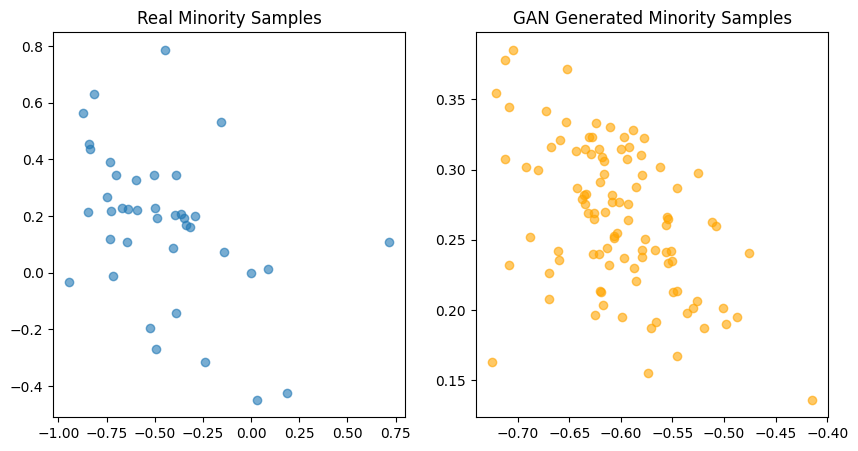

[GAN] Epoch 16 | D Loss: 1.3707 | G Loss: 0.7596
[GAN] Epoch 17 | D Loss: 1.3689 | G Loss: 0.7649
[GAN] Epoch 18 | D Loss: 1.3662 | G Loss: 0.7668
[GAN] Epoch 19 | D Loss: 1.3702 | G Loss: 0.7688
[GAN] Epoch 20 | D Loss: 1.3653 | G Loss: 0.7709


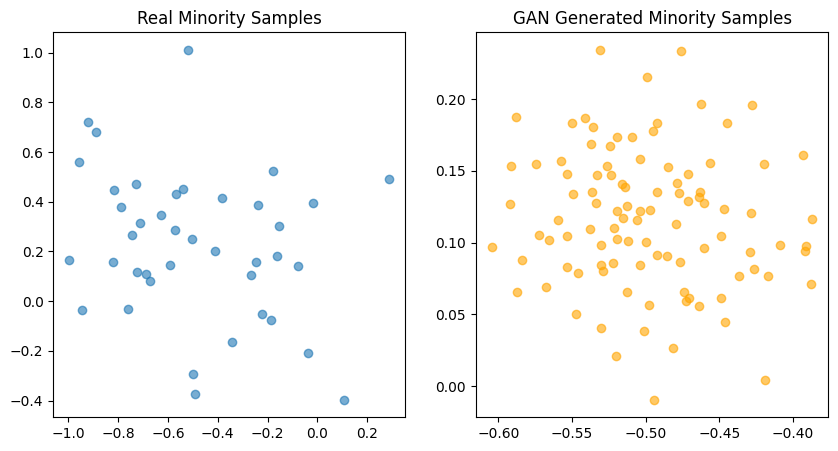

[GAN] Epoch 21 | D Loss: 1.3638 | G Loss: 0.7736
[GAN] Epoch 22 | D Loss: 1.3641 | G Loss: 0.7750
[GAN] Epoch 23 | D Loss: 1.3650 | G Loss: 0.7744
[GAN] Epoch 24 | D Loss: 1.3717 | G Loss: 0.7739
[GAN] Epoch 25 | D Loss: 1.3695 | G Loss: 0.7743


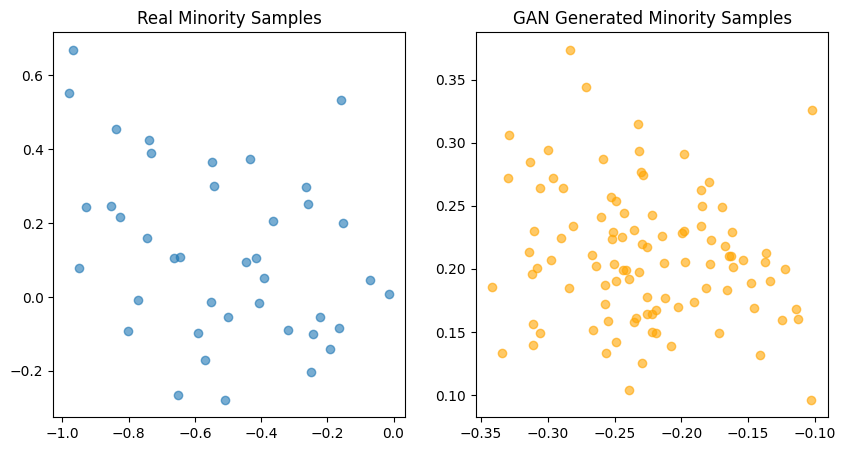

[GAN] Epoch 26 | D Loss: 1.3687 | G Loss: 0.7744
[GAN] Epoch 27 | D Loss: 1.3684 | G Loss: 0.7744
[GAN] Epoch 28 | D Loss: 1.3623 | G Loss: 0.7747
[GAN] Epoch 29 | D Loss: 1.3686 | G Loss: 0.7761
[GAN] Epoch 30 | D Loss: 1.3762 | G Loss: 0.7774


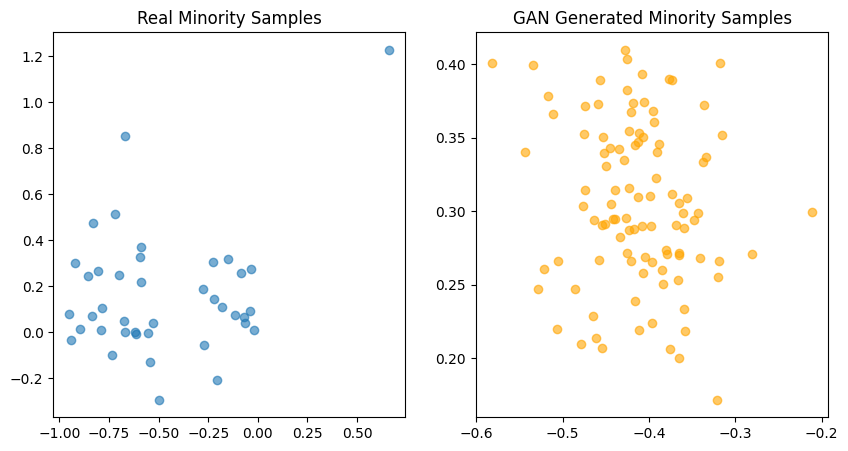

[GAN] Epoch 31 | D Loss: 1.3652 | G Loss: 0.7788
[GAN] Epoch 32 | D Loss: 1.3691 | G Loss: 0.7786
[GAN] Epoch 33 | D Loss: 1.3813 | G Loss: 0.7776
[GAN] Epoch 34 | D Loss: 1.3746 | G Loss: 0.7805
[GAN] Epoch 35 | D Loss: 1.3592 | G Loss: 0.7838


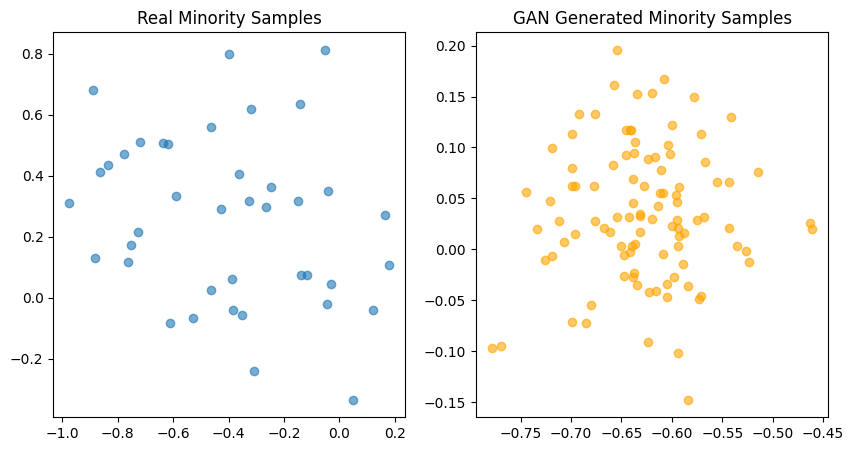

[GAN] Epoch 36 | D Loss: 1.3725 | G Loss: 0.7872
[GAN] Epoch 37 | D Loss: 1.3569 | G Loss: 0.7861
[GAN] Epoch 38 | D Loss: 1.3631 | G Loss: 0.7836
[GAN] Epoch 39 | D Loss: 1.3763 | G Loss: 0.7815
[GAN] Epoch 40 | D Loss: 1.3770 | G Loss: 0.7845


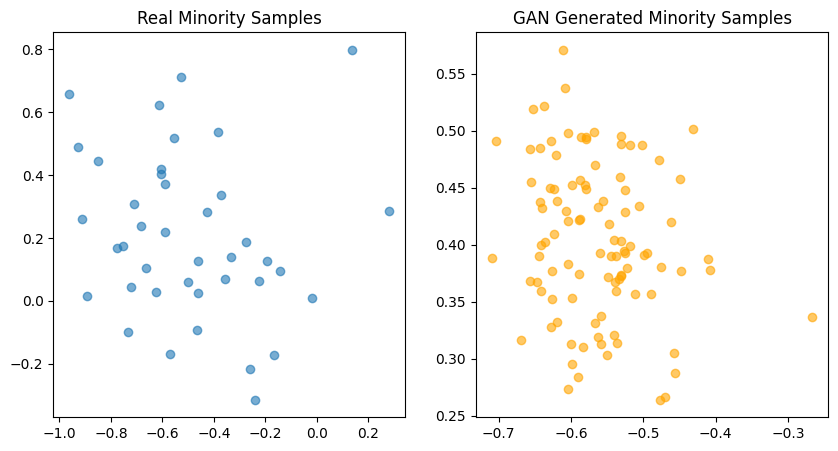

[GAN] Epoch 41 | D Loss: 1.3664 | G Loss: 0.7876
[GAN] Epoch 42 | D Loss: 1.3702 | G Loss: 0.7895
[GAN] Epoch 43 | D Loss: 1.3575 | G Loss: 0.7879
[GAN] Epoch 44 | D Loss: 1.3585 | G Loss: 0.7852
[GAN] Epoch 45 | D Loss: 1.3718 | G Loss: 0.7794


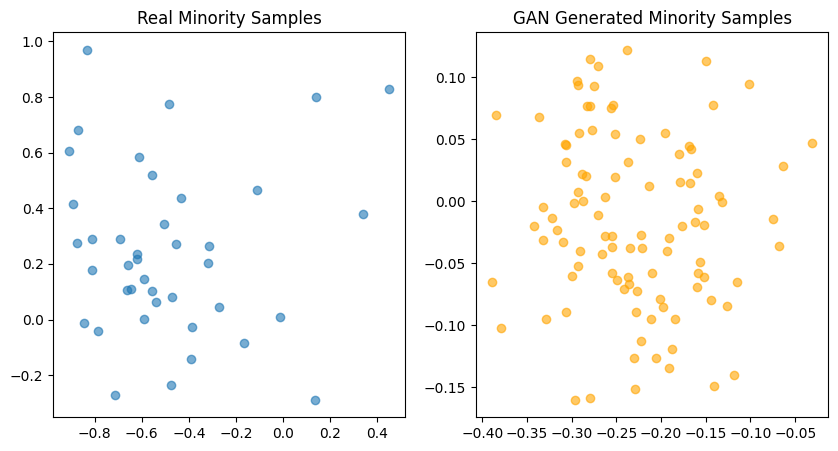

[GAN] Epoch 46 | D Loss: 1.3651 | G Loss: 0.7774
[GAN] Epoch 47 | D Loss: 1.3744 | G Loss: 0.7760
[GAN] Epoch 48 | D Loss: 1.3550 | G Loss: 0.7776
[GAN] Epoch 49 | D Loss: 1.3536 | G Loss: 0.7797
[GAN] Epoch 50 | D Loss: 1.3757 | G Loss: 0.7813


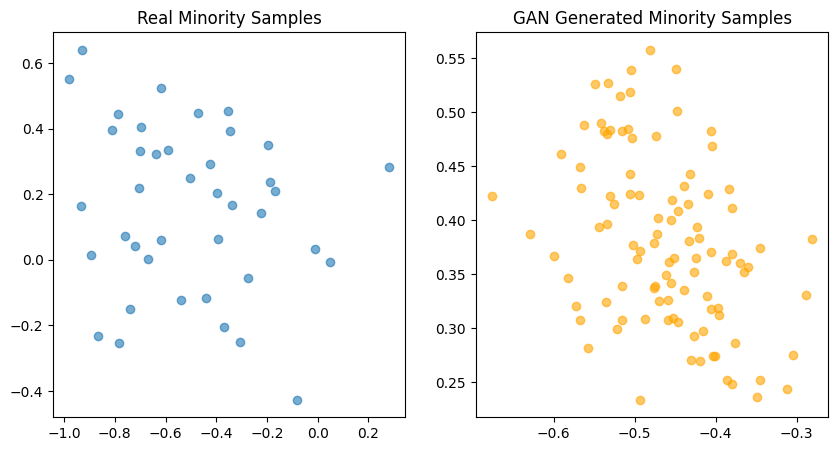

[GAN] Epoch 51 | D Loss: 1.3748 | G Loss: 0.7827
[GAN] Epoch 52 | D Loss: 1.3668 | G Loss: 0.7846
[GAN] Epoch 53 | D Loss: 1.3665 | G Loss: 0.7871
[GAN] Epoch 54 | D Loss: 1.3741 | G Loss: 0.7892
[GAN] Epoch 55 | D Loss: 1.3510 | G Loss: 0.7904


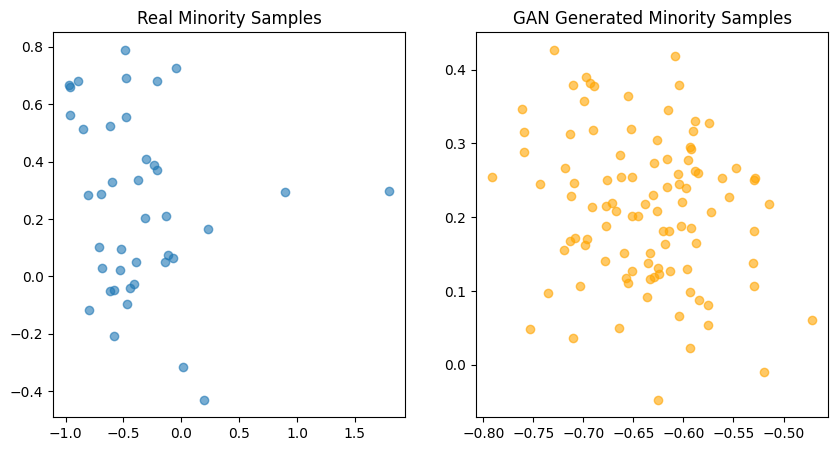

[GAN] Epoch 56 | D Loss: 1.3668 | G Loss: 0.7923
[GAN] Epoch 57 | D Loss: 1.3668 | G Loss: 0.7925
[GAN] Epoch 58 | D Loss: 1.3591 | G Loss: 0.7936
[GAN] Epoch 59 | D Loss: 1.3588 | G Loss: 0.7897
[GAN] Epoch 60 | D Loss: 1.3706 | G Loss: 0.7866


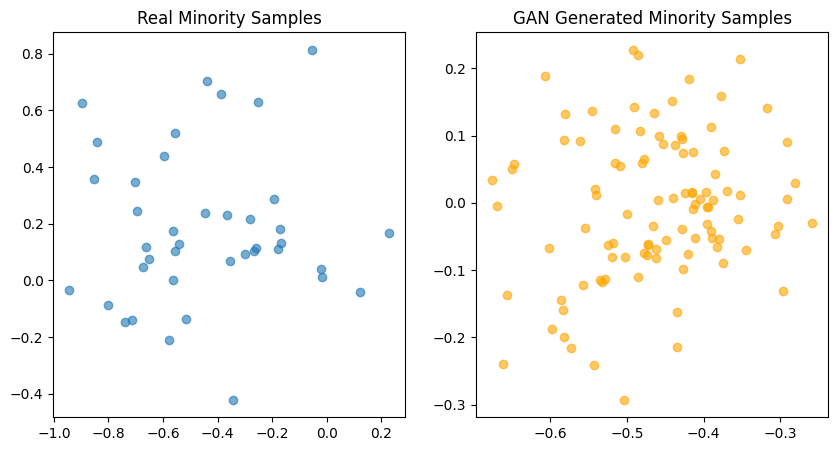

[GAN] Epoch 61 | D Loss: 1.3646 | G Loss: 0.7850
[GAN] Epoch 62 | D Loss: 1.3654 | G Loss: 0.7859
[GAN] Epoch 63 | D Loss: 1.3654 | G Loss: 0.7902
[GAN] Epoch 64 | D Loss: 1.3683 | G Loss: 0.7942
[GAN] Epoch 65 | D Loss: 1.3469 | G Loss: 0.7948


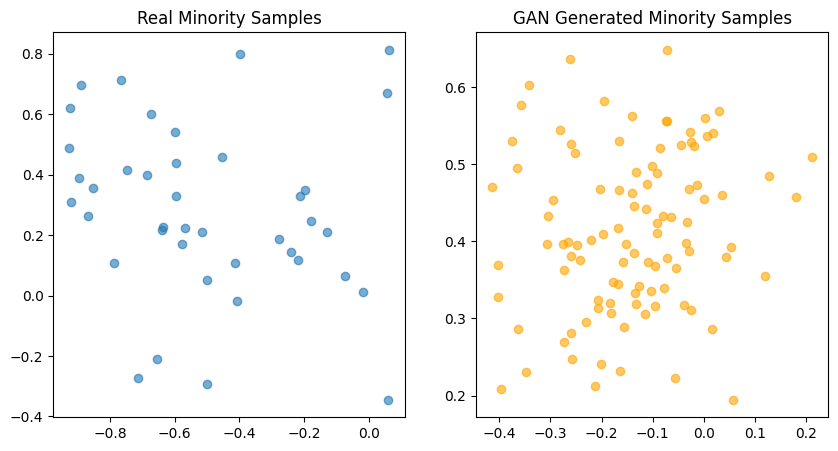

[GAN] Epoch 66 | D Loss: 1.3532 | G Loss: 0.7906
[GAN] Epoch 67 | D Loss: 1.3582 | G Loss: 0.7848
[GAN] Epoch 68 | D Loss: 1.3747 | G Loss: 0.7793
[GAN] Epoch 69 | D Loss: 1.3782 | G Loss: 0.7744
[GAN] Epoch 70 | D Loss: 1.3803 | G Loss: 0.7726


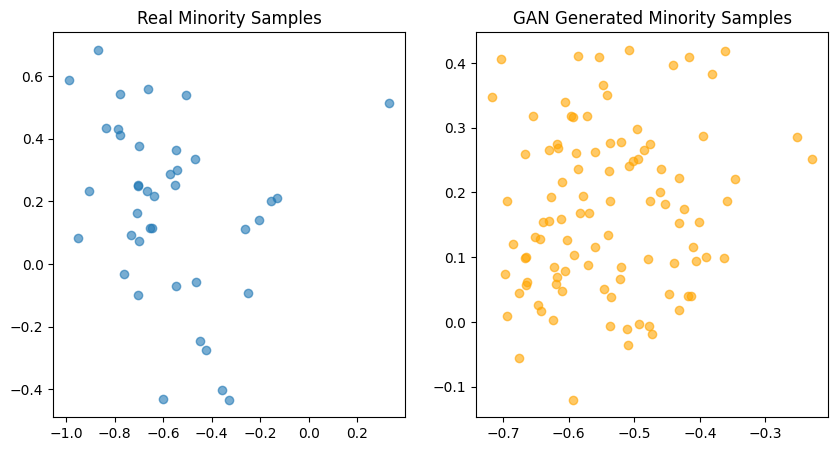

[GAN] Epoch 71 | D Loss: 1.3716 | G Loss: 0.7739
[GAN] Epoch 72 | D Loss: 1.3681 | G Loss: 0.7769
[GAN] Epoch 73 | D Loss: 1.3725 | G Loss: 0.7806
[GAN] Epoch 74 | D Loss: 1.3665 | G Loss: 0.7850
[GAN] Epoch 75 | D Loss: 1.3577 | G Loss: 0.7890


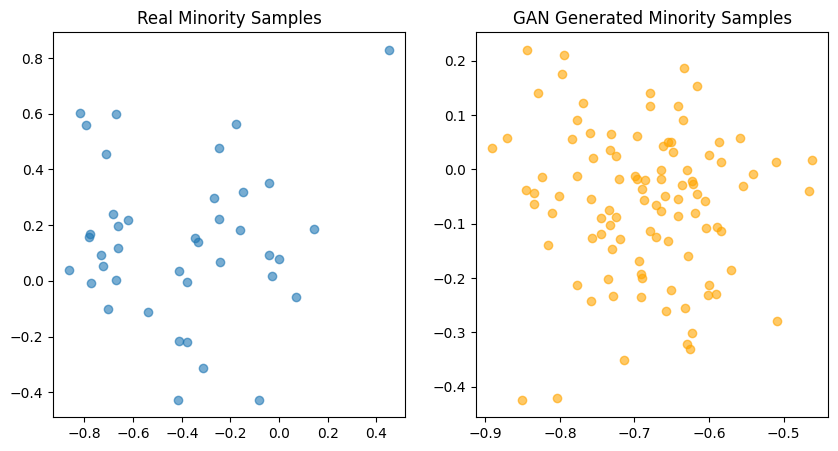

[GAN] Epoch 76 | D Loss: 1.3736 | G Loss: 0.7895
[GAN] Epoch 77 | D Loss: 1.3746 | G Loss: 0.7882
[GAN] Epoch 78 | D Loss: 1.3653 | G Loss: 0.7904
[GAN] Epoch 79 | D Loss: 1.3632 | G Loss: 0.7902
[GAN] Epoch 80 | D Loss: 1.3504 | G Loss: 0.7950


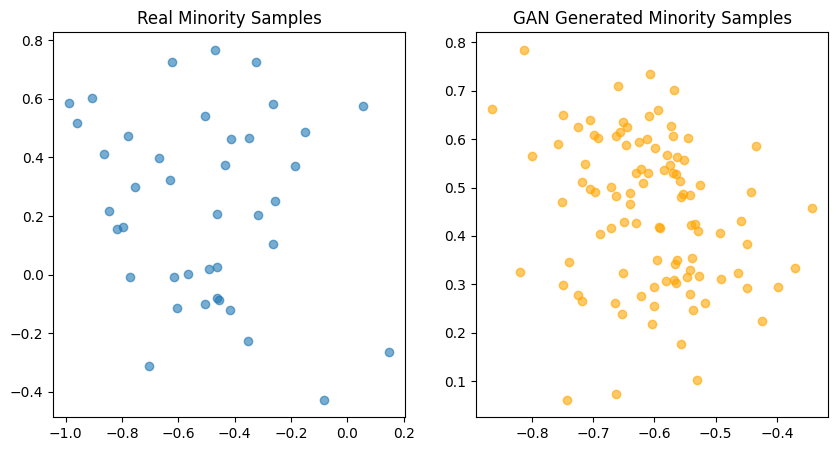

[GAN] Epoch 81 | D Loss: 1.3680 | G Loss: 0.8018
[GAN] Epoch 82 | D Loss: 1.3630 | G Loss: 0.8073
[GAN] Epoch 83 | D Loss: 1.3678 | G Loss: 0.8053
[GAN] Epoch 84 | D Loss: 1.3543 | G Loss: 0.8006
[GAN] Epoch 85 | D Loss: 1.3825 | G Loss: 0.7904


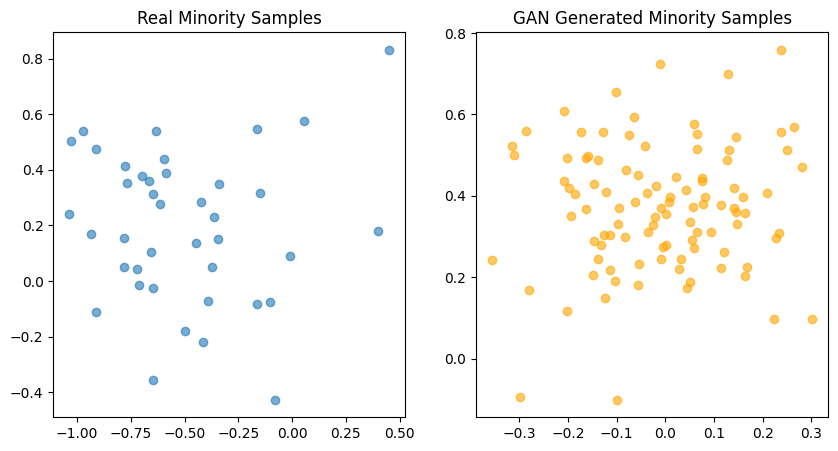

[GAN] Epoch 86 | D Loss: 1.3793 | G Loss: 0.7776
[GAN] Epoch 87 | D Loss: 1.3745 | G Loss: 0.7717
[GAN] Epoch 88 | D Loss: 1.3686 | G Loss: 0.7735
[GAN] Epoch 89 | D Loss: 1.3665 | G Loss: 0.7807
[GAN] Epoch 90 | D Loss: 1.3670 | G Loss: 0.7864


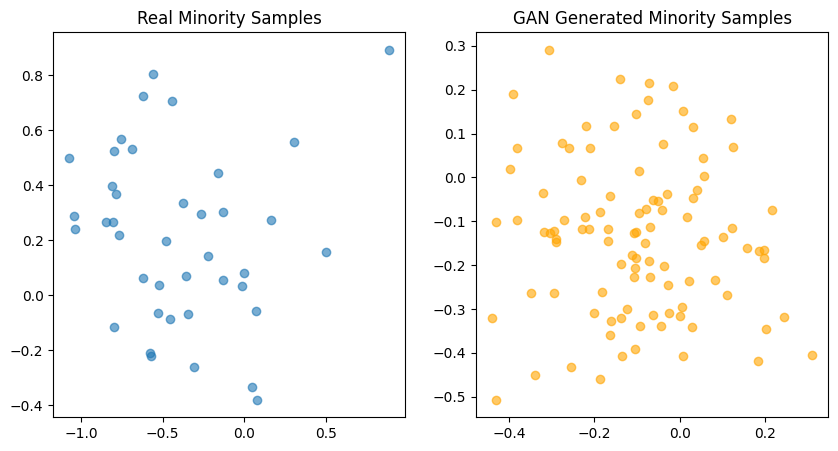

[GAN] Epoch 91 | D Loss: 1.3670 | G Loss: 0.7924
[GAN] Epoch 92 | D Loss: 1.3274 | G Loss: 0.7966
[GAN] Epoch 93 | D Loss: 1.3502 | G Loss: 0.8028
[GAN] Epoch 94 | D Loss: 1.3370 | G Loss: 0.7987
[GAN] Epoch 95 | D Loss: 1.3289 | G Loss: 0.7947


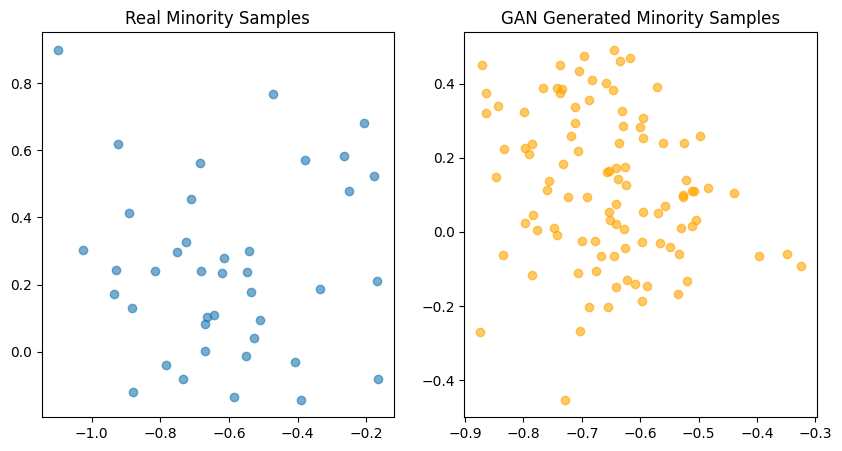

[GAN] Epoch 96 | D Loss: 1.3495 | G Loss: 0.7888
[GAN] Epoch 97 | D Loss: 1.3498 | G Loss: 0.7899
[GAN] Epoch 98 | D Loss: 1.3689 | G Loss: 0.7834
[GAN] Epoch 99 | D Loss: 1.3766 | G Loss: 0.7892
[GAN] Epoch 100 | D Loss: 1.3909 | G Loss: 0.7865


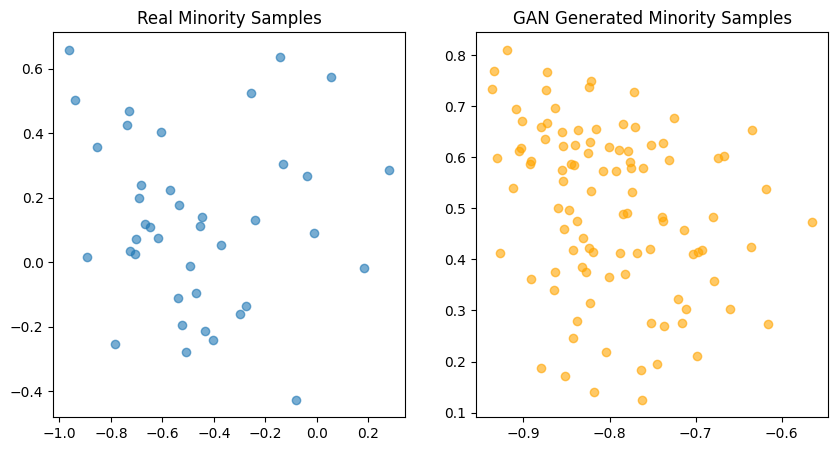

In [18]:
G = Generator(latent_dim, input_dim).to(device)
D = Discriminator(input_dim).to(device)
G.apply(weights_init)
D.apply(weights_init)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

for epoch in range(100):
    for batch in dataloader:
        real_samples = batch[0].to(device)
        real_labels = torch.full((real_samples.size(0), 1), 0.9, device=device)
        fake_labels = torch.zeros(real_samples.size(0), 1, device=device)

        optimizer_D.zero_grad()
        z = torch.randn(real_samples.size(0), latent_dim, device=device)
        fake = G(z)
        d_loss = criterion(D(real_samples), real_labels) + criterion(D(fake.detach()), fake_labels)
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        g_loss = criterion(D(fake), real_labels)
        g_loss.backward()
        optimizer_G.step()

    print(f"[GAN] Epoch {epoch+1} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            fake = G(torch.randn(100, latent_dim, device=device)).cpu().numpy()
            real = real_samples[:100].cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.scatter(real[:, 0], real[:, 1], alpha=0.6)
            plt.title("Real Minority Samples")
            plt.subplot(1, 2, 2)
            plt.scatter(fake[:, 0], fake[:, 1], alpha=0.6, color='orange')
            plt.title("GAN Generated Minority Samples")
            plt.show()


**Generator Loss (G Loss)**
Goal: Fool the discriminator (make D(fake) → 1)

Ideal:
- Starts high
- Decreases gradually as G improves
- Shouldn't collapse to 0 too quickly (means D is too weak)
- Shouldn’t oscillate wildly either
- You want G Loss to steadily go down (but not to zero)


**Discriminator Loss (D Loss)**
Goal: Distinguish real vs. fake accurately

Ideal:
- Starts low, increases as G improves
- Should stay around ~1.0 when G and D are balanced
- Too high (> 1.5): D is struggling → G is too strong
- Too low (< 0.3): D is too powerful → G can’t learn
- So: you want D Loss to hover around ~1.0
- It should not go to zero and not explode.

**Note:**

D Loss = 1.38: Slightly high — G may be getting stronger.

G Loss = 0.76: Reasonable — G is starting to produce convincing samples.


## Train WGAN on Minority Class

[WGAN] Epoch 1 | Critic Loss: -0.0101 | Generator Loss: 0.0122
[WGAN] Epoch 2 | Critic Loss: -0.0169 | Generator Loss: 0.0138
[WGAN] Epoch 3 | Critic Loss: -0.0184 | Generator Loss: 0.0160
[WGAN] Epoch 4 | Critic Loss: -0.0201 | Generator Loss: 0.0166
[WGAN] Epoch 5 | Critic Loss: -0.0220 | Generator Loss: 0.0174


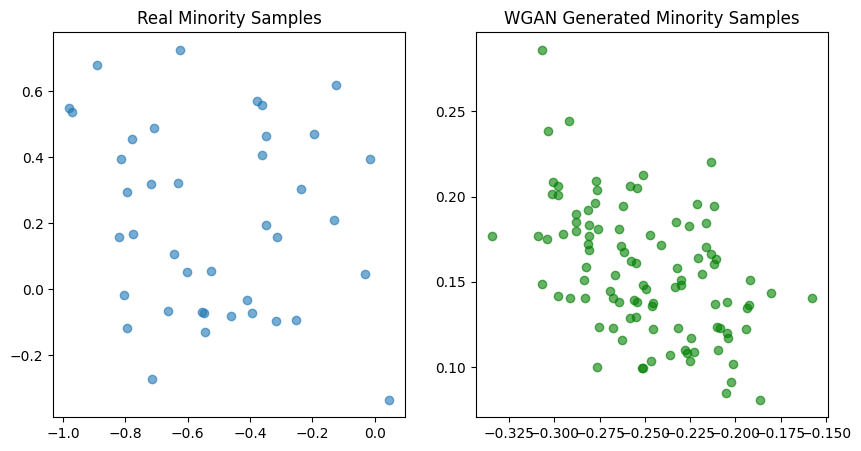

[WGAN] Epoch 6 | Critic Loss: -0.0223 | Generator Loss: 0.0175
[WGAN] Epoch 7 | Critic Loss: -0.0169 | Generator Loss: 0.0179
[WGAN] Epoch 8 | Critic Loss: -0.0173 | Generator Loss: 0.0172
[WGAN] Epoch 9 | Critic Loss: -0.0181 | Generator Loss: 0.0180
[WGAN] Epoch 10 | Critic Loss: -0.0200 | Generator Loss: 0.0180


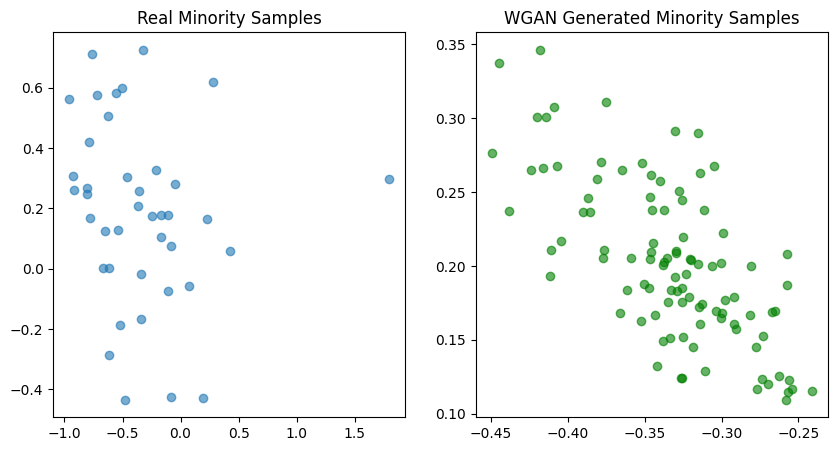

[WGAN] Epoch 11 | Critic Loss: -0.0134 | Generator Loss: 0.0182
[WGAN] Epoch 12 | Critic Loss: -0.0132 | Generator Loss: 0.0185
[WGAN] Epoch 13 | Critic Loss: -0.0139 | Generator Loss: 0.0182
[WGAN] Epoch 14 | Critic Loss: -0.0153 | Generator Loss: 0.0182
[WGAN] Epoch 15 | Critic Loss: -0.0177 | Generator Loss: 0.0190


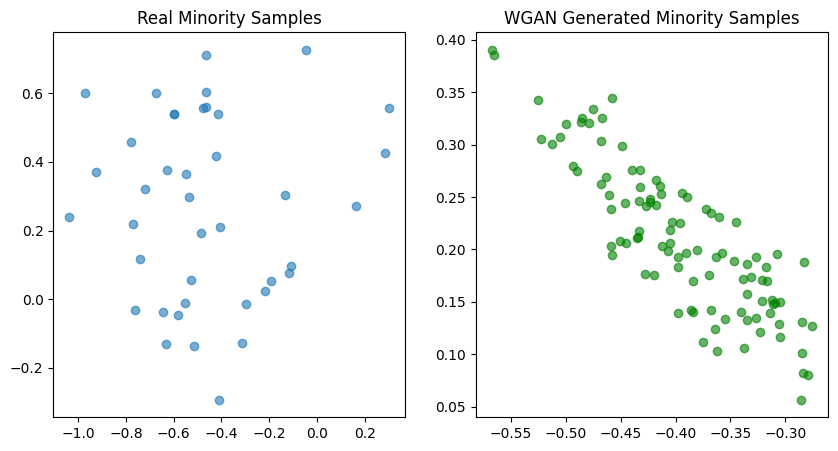

[WGAN] Epoch 16 | Critic Loss: -0.0123 | Generator Loss: 0.0181
[WGAN] Epoch 17 | Critic Loss: -0.0140 | Generator Loss: 0.0185
[WGAN] Epoch 18 | Critic Loss: -0.0123 | Generator Loss: 0.0179
[WGAN] Epoch 19 | Critic Loss: -0.0132 | Generator Loss: 0.0188
[WGAN] Epoch 20 | Critic Loss: -0.0169 | Generator Loss: 0.0181


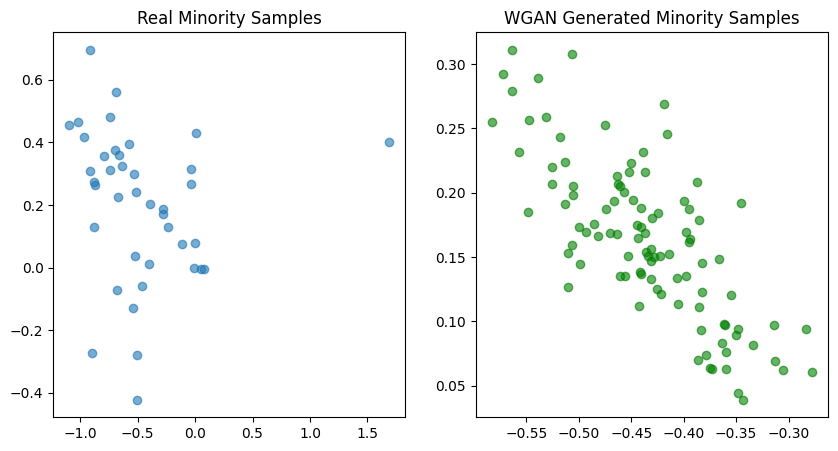

[WGAN] Epoch 21 | Critic Loss: -0.0101 | Generator Loss: 0.0187
[WGAN] Epoch 22 | Critic Loss: -0.0150 | Generator Loss: 0.0182
[WGAN] Epoch 23 | Critic Loss: -0.0157 | Generator Loss: 0.0182
[WGAN] Epoch 24 | Critic Loss: -0.0111 | Generator Loss: 0.0190
[WGAN] Epoch 25 | Critic Loss: -0.0121 | Generator Loss: 0.0182


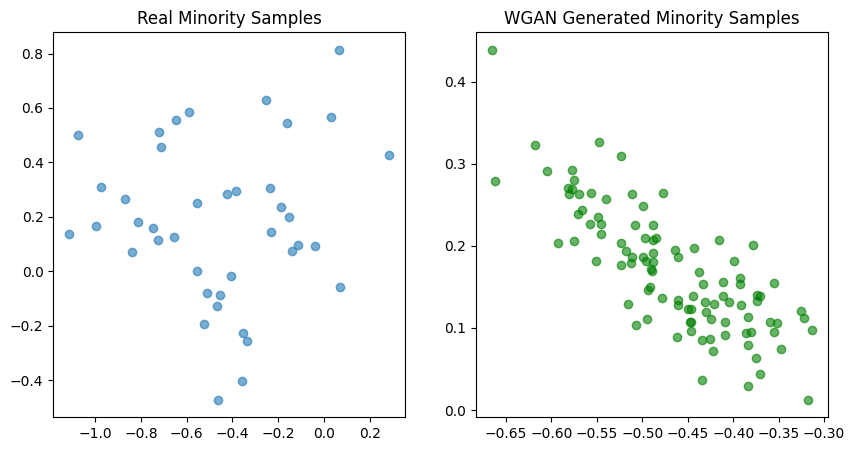

[WGAN] Epoch 26 | Critic Loss: -0.0147 | Generator Loss: 0.0180
[WGAN] Epoch 27 | Critic Loss: -0.0127 | Generator Loss: 0.0177
[WGAN] Epoch 28 | Critic Loss: -0.0098 | Generator Loss: 0.0176
[WGAN] Epoch 29 | Critic Loss: -0.0102 | Generator Loss: 0.0187
[WGAN] Epoch 30 | Critic Loss: -0.0111 | Generator Loss: 0.0182


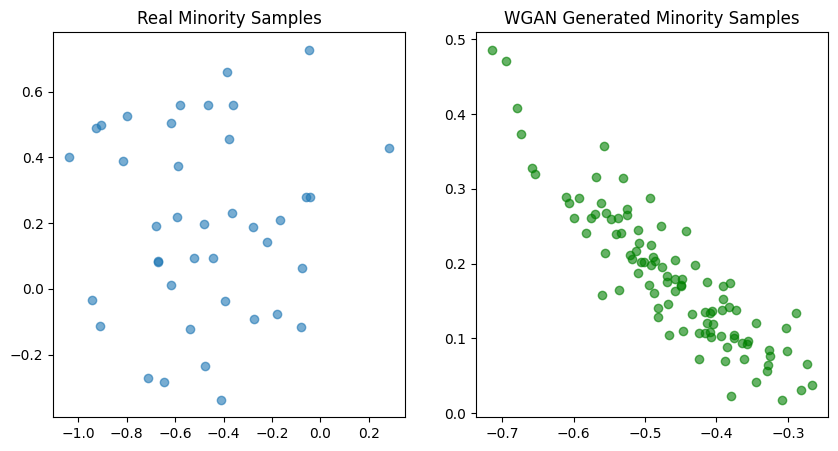

[WGAN] Epoch 31 | Critic Loss: -0.0108 | Generator Loss: 0.0180
[WGAN] Epoch 32 | Critic Loss: -0.0101 | Generator Loss: 0.0183
[WGAN] Epoch 33 | Critic Loss: -0.0100 | Generator Loss: 0.0168
[WGAN] Epoch 34 | Critic Loss: -0.0078 | Generator Loss: 0.0181
[WGAN] Epoch 35 | Critic Loss: -0.0090 | Generator Loss: 0.0171


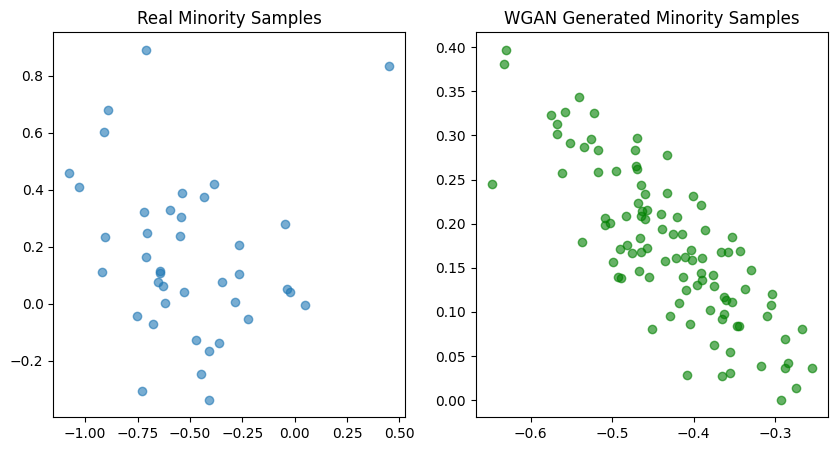

[WGAN] Epoch 36 | Critic Loss: -0.0118 | Generator Loss: 0.0177
[WGAN] Epoch 37 | Critic Loss: -0.0109 | Generator Loss: 0.0171
[WGAN] Epoch 38 | Critic Loss: -0.0073 | Generator Loss: 0.0176
[WGAN] Epoch 39 | Critic Loss: -0.0068 | Generator Loss: 0.0170
[WGAN] Epoch 40 | Critic Loss: -0.0060 | Generator Loss: 0.0168


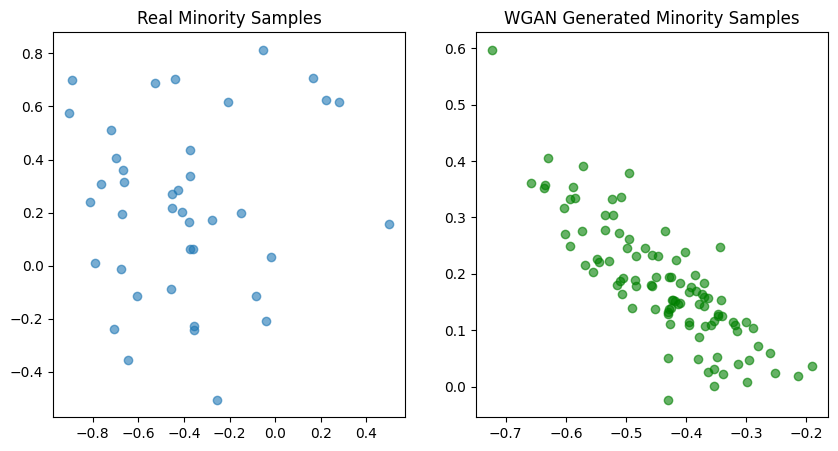

[WGAN] Epoch 41 | Critic Loss: -0.0073 | Generator Loss: 0.0173
[WGAN] Epoch 42 | Critic Loss: -0.0108 | Generator Loss: 0.0168
[WGAN] Epoch 43 | Critic Loss: -0.0051 | Generator Loss: 0.0159
[WGAN] Epoch 44 | Critic Loss: -0.0069 | Generator Loss: 0.0157
[WGAN] Epoch 45 | Critic Loss: -0.0070 | Generator Loss: 0.0168


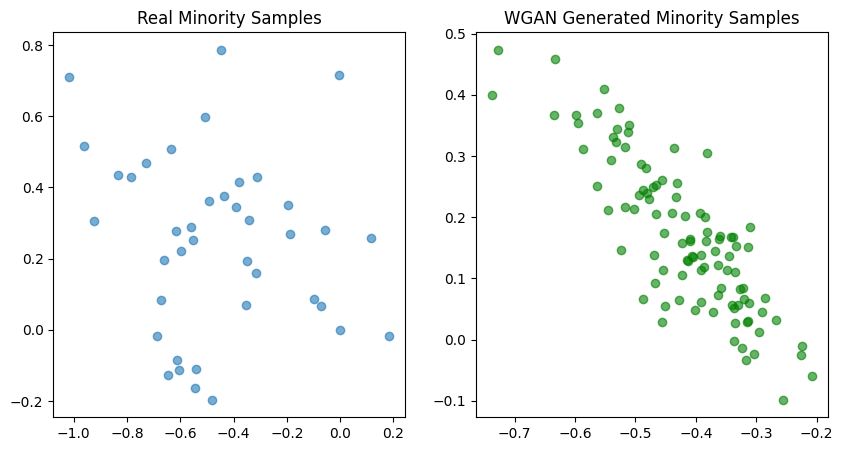

[WGAN] Epoch 46 | Critic Loss: -0.0071 | Generator Loss: 0.0166
[WGAN] Epoch 47 | Critic Loss: -0.0075 | Generator Loss: 0.0159
[WGAN] Epoch 48 | Critic Loss: -0.0040 | Generator Loss: 0.0166
[WGAN] Epoch 49 | Critic Loss: -0.0087 | Generator Loss: 0.0157
[WGAN] Epoch 50 | Critic Loss: -0.0072 | Generator Loss: 0.0159


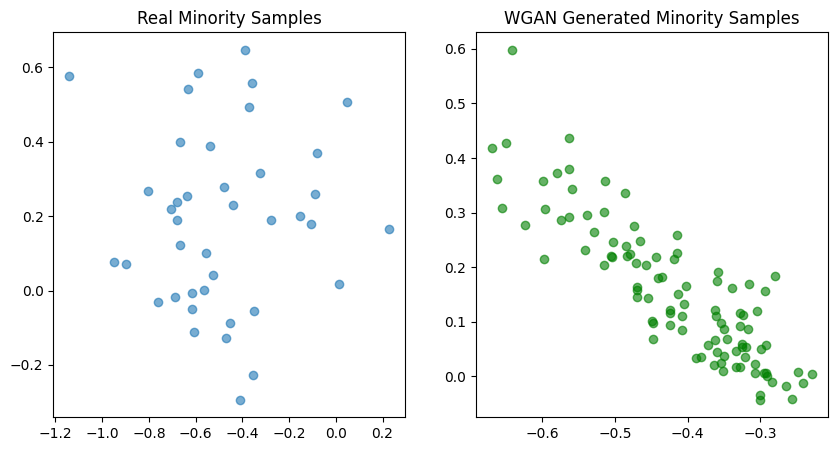

[WGAN] Epoch 51 | Critic Loss: -0.0063 | Generator Loss: 0.0167
[WGAN] Epoch 52 | Critic Loss: -0.0067 | Generator Loss: 0.0159
[WGAN] Epoch 53 | Critic Loss: -0.0051 | Generator Loss: 0.0158
[WGAN] Epoch 54 | Critic Loss: -0.0060 | Generator Loss: 0.0156
[WGAN] Epoch 55 | Critic Loss: -0.0047 | Generator Loss: 0.0162


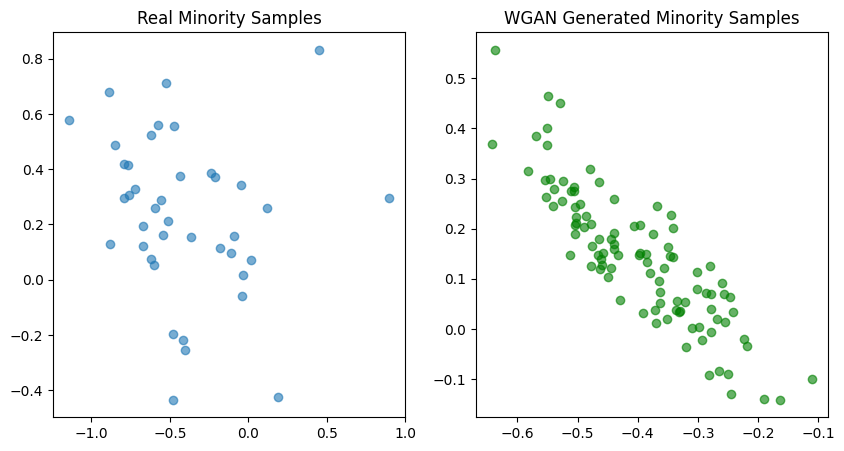

[WGAN] Epoch 56 | Critic Loss: -0.0078 | Generator Loss: 0.0150
[WGAN] Epoch 57 | Critic Loss: -0.0055 | Generator Loss: 0.0159
[WGAN] Epoch 58 | Critic Loss: -0.0038 | Generator Loss: 0.0163
[WGAN] Epoch 59 | Critic Loss: -0.0055 | Generator Loss: 0.0167
[WGAN] Epoch 60 | Critic Loss: -0.0028 | Generator Loss: 0.0155


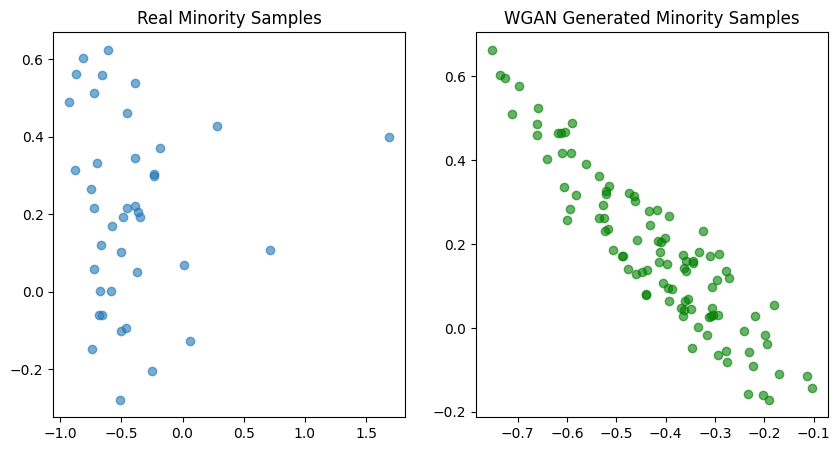

[WGAN] Epoch 61 | Critic Loss: -0.0060 | Generator Loss: 0.0159
[WGAN] Epoch 62 | Critic Loss: -0.0045 | Generator Loss: 0.0154
[WGAN] Epoch 63 | Critic Loss: -0.0077 | Generator Loss: 0.0150
[WGAN] Epoch 64 | Critic Loss: -0.0054 | Generator Loss: 0.0160
[WGAN] Epoch 65 | Critic Loss: -0.0058 | Generator Loss: 0.0164


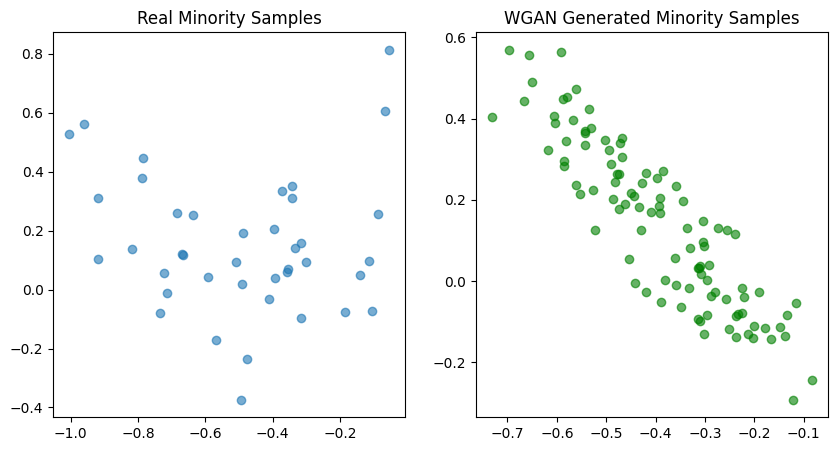

[WGAN] Epoch 66 | Critic Loss: -0.0049 | Generator Loss: 0.0162
[WGAN] Epoch 67 | Critic Loss: -0.0066 | Generator Loss: 0.0160
[WGAN] Epoch 68 | Critic Loss: -0.0028 | Generator Loss: 0.0168
[WGAN] Epoch 69 | Critic Loss: -0.0028 | Generator Loss: 0.0169
[WGAN] Epoch 70 | Critic Loss: -0.0054 | Generator Loss: 0.0157


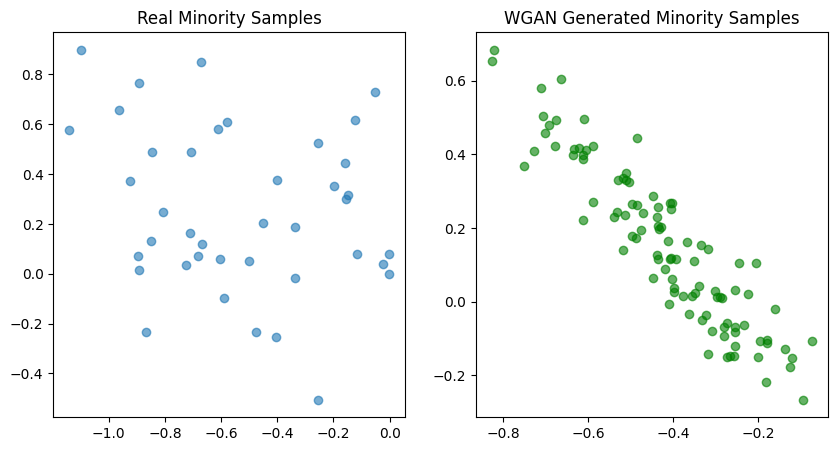

[WGAN] Epoch 71 | Critic Loss: -0.0063 | Generator Loss: 0.0161
[WGAN] Epoch 72 | Critic Loss: -0.0026 | Generator Loss: 0.0170
[WGAN] Epoch 73 | Critic Loss: -0.0059 | Generator Loss: 0.0154
[WGAN] Epoch 74 | Critic Loss: -0.0038 | Generator Loss: 0.0164
[WGAN] Epoch 75 | Critic Loss: -0.0030 | Generator Loss: 0.0172


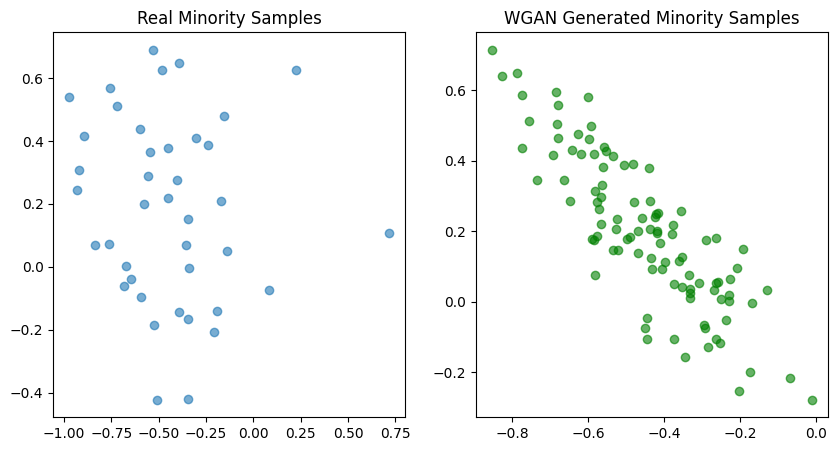

[WGAN] Epoch 76 | Critic Loss: -0.0040 | Generator Loss: 0.0162
[WGAN] Epoch 77 | Critic Loss: -0.0032 | Generator Loss: 0.0164
[WGAN] Epoch 78 | Critic Loss: -0.0042 | Generator Loss: 0.0159
[WGAN] Epoch 79 | Critic Loss: -0.0030 | Generator Loss: 0.0155
[WGAN] Epoch 80 | Critic Loss: -0.0033 | Generator Loss: 0.0154


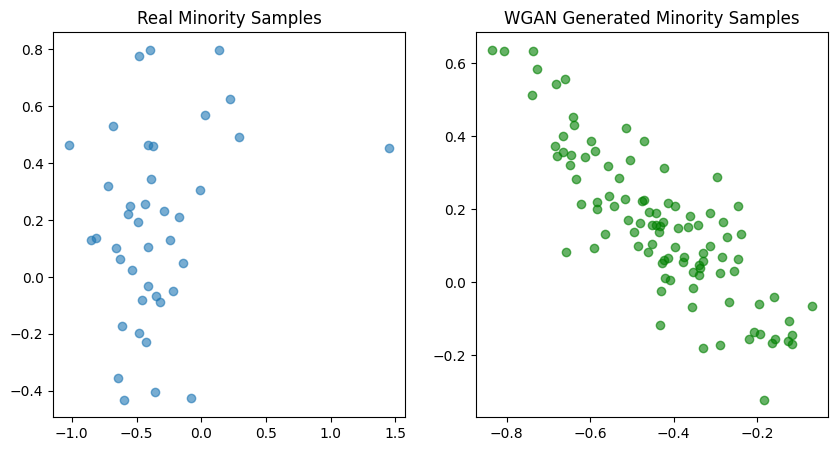

[WGAN] Epoch 81 | Critic Loss: -0.0032 | Generator Loss: 0.0148
[WGAN] Epoch 82 | Critic Loss: -0.0033 | Generator Loss: 0.0148
[WGAN] Epoch 83 | Critic Loss: -0.0014 | Generator Loss: 0.0147
[WGAN] Epoch 84 | Critic Loss: -0.0046 | Generator Loss: 0.0142
[WGAN] Epoch 85 | Critic Loss: -0.0017 | Generator Loss: 0.0150


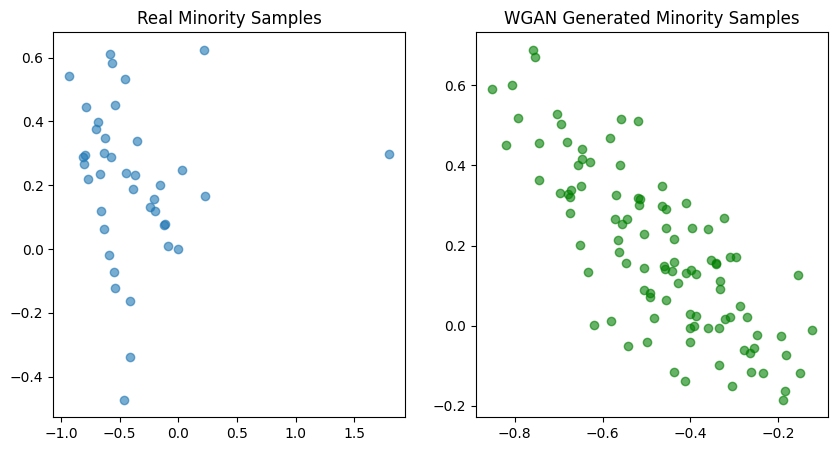

[WGAN] Epoch 86 | Critic Loss: -0.0054 | Generator Loss: 0.0145
[WGAN] Epoch 87 | Critic Loss: -0.0053 | Generator Loss: 0.0143
[WGAN] Epoch 88 | Critic Loss: -0.0044 | Generator Loss: 0.0143
[WGAN] Epoch 89 | Critic Loss: -0.0045 | Generator Loss: 0.0140
[WGAN] Epoch 90 | Critic Loss: -0.0043 | Generator Loss: 0.0142


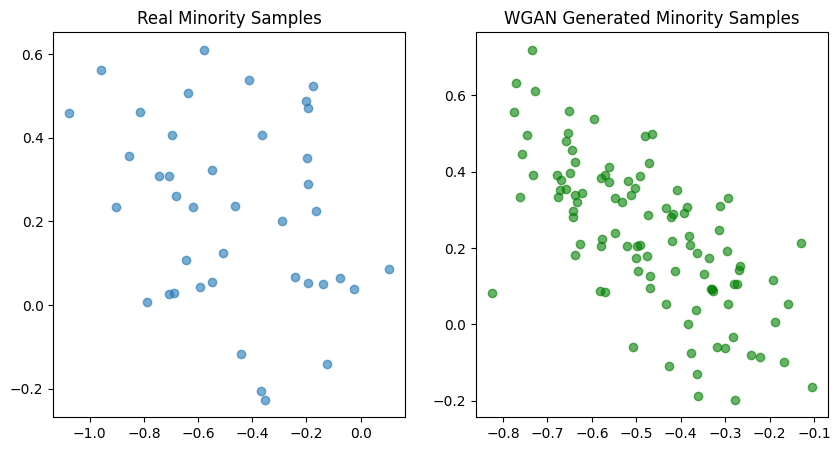

[WGAN] Epoch 91 | Critic Loss: -0.0057 | Generator Loss: 0.0141
[WGAN] Epoch 92 | Critic Loss: -0.0044 | Generator Loss: 0.0135
[WGAN] Epoch 93 | Critic Loss: -0.0039 | Generator Loss: 0.0140
[WGAN] Epoch 94 | Critic Loss: -0.0036 | Generator Loss: 0.0142
[WGAN] Epoch 95 | Critic Loss: -0.0038 | Generator Loss: 0.0138


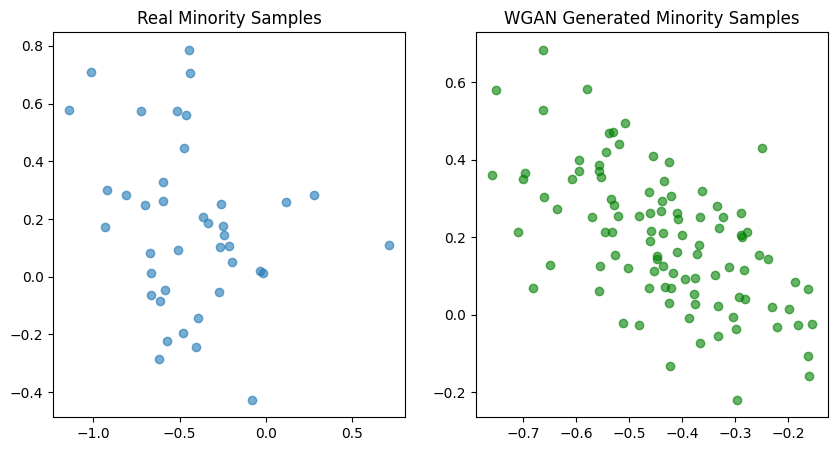

[WGAN] Epoch 96 | Critic Loss: -0.0046 | Generator Loss: 0.0143
[WGAN] Epoch 97 | Critic Loss: -0.0036 | Generator Loss: 0.0144
[WGAN] Epoch 98 | Critic Loss: -0.0047 | Generator Loss: 0.0140
[WGAN] Epoch 99 | Critic Loss: -0.0066 | Generator Loss: 0.0147
[WGAN] Epoch 100 | Critic Loss: -0.0031 | Generator Loss: 0.0144


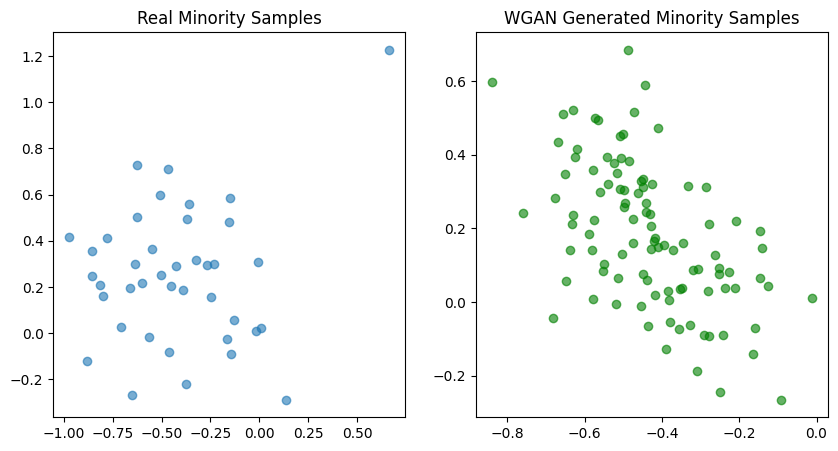

In [19]:
class Critic(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # self.model = nn.Sequential(
        #     nn.Linear(input_dim, 128),
        #     nn.LeakyReLU(0.2),
        #     nn.Linear(128, 1)
        # )
        self.model = nn.Sequential(
        nn.Linear(input_dim, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 128),
        nn.LeakyReLU(0.2),
        nn.Linear(128, 1)
)

    def forward(self, x):
        return self.model(x)

G_wgan = Generator(latent_dim, input_dim).to(device)
C_wgan = Critic(input_dim).to(device)
G_wgan.apply(weights_init)
C_wgan.apply(weights_init)

optimizer_G = optim.RMSprop(G_wgan.parameters(), lr=0.00005)
optimizer_C = optim.RMSprop(C_wgan.parameters(), lr=0.00005)

for epoch in range(100):
    for batch in dataloader:
        real_samples = batch[0].to(device)

        for _ in range(5):
            optimizer_C.zero_grad()
            z = torch.randn(real_samples.size(0), latent_dim, device=device)
            fake = G_wgan(z).detach()
            loss_c = -torch.mean(C_wgan(real_samples)) + torch.mean(C_wgan(fake))
            loss_c.backward()
            optimizer_C.step()
            for p in C_wgan.parameters():
                p.data.clamp_(-0.01, 0.01)

        optimizer_G.zero_grad()
        z = torch.randn(real_samples.size(0), latent_dim, device=device)
        loss_g = -torch.mean(C_wgan(G_wgan(z)))
        loss_g.backward()
        optimizer_G.step()

    print(f"[WGAN] Epoch {epoch+1} | Critic Loss: {loss_c.item():.4f} | Generator Loss: {loss_g.item():.4f}")
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            fake = G_wgan(torch.randn(100, latent_dim, device=device)).cpu().numpy()
            real = real_samples[:100].cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.scatter(real[:, 0], real[:, 1], alpha=0.6)
            plt.title("Real Minority Samples")
            plt.subplot(1, 2, 2)
            plt.scatter(fake[:, 0], fake[:, 1], alpha=0.6, color='green')
            plt.title("WGAN Generated Minority Samples")
            plt.show()


In WGAN (Wasserstein GAN):

- Critic Loss = -mean(D(real)) + mean(D(fake))

Lower = better separation between real and fake

Goal: minimize this

- Generator Loss = -mean(D(fake))

Goal: maximize the critic's belief that fake is real (i.e., make D(fake) high)

In [21]:
G

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=11, bias=True)
    (3): Tanh()
  )
)

In [23]:
for name, param in G.named_parameters():
    print(name, param, param.shape)

model.0.weight Parameter containing:
tensor([[ 0.0780,  0.0231,  0.0205,  ..., -0.0269, -0.0945, -0.0062],
        [ 0.0792,  0.0023,  0.0710,  ...,  0.1197, -0.0836, -0.0121],
        [ 0.0085, -0.0055,  0.0783,  ..., -0.0017, -0.0009,  0.1005],
        ...,
        [ 0.0325,  0.0199,  0.0268,  ..., -0.0293, -0.0550, -0.0182],
        [-0.0347, -0.0308,  0.0506,  ...,  0.0020, -0.0266,  0.0423],
        [ 0.0422,  0.0714, -0.0284,  ...,  0.0384,  0.0748, -0.0282]],
       requires_grad=True) torch.Size([128, 100])
model.0.bias Parameter containing:
tensor([ 0.1084,  0.0172,  0.1028,  0.0304,  0.1606,  0.1629,  0.0284,  0.1087,
         0.1523,  0.0483,  0.1795,  0.0490,  0.0977,  0.0717,  0.0182,  0.0217,
         0.0738,  0.0558,  0.1161,  0.1527,  0.1451,  0.1355,  0.1726,  0.0840,
         0.0898,  0.1717,  0.0231,  0.0987,  0.0804,  0.1675,  0.0039,  0.0237,
         0.1962,  0.1380,  0.0220,  0.0152,  0.1682,  0.0441,  0.1630,  0.1777,
        -0.0492,  0.1701,  0.0990, -0.0381, 

In [20]:
G

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=11, bias=True)
    (3): Tanh()
  )
)

**Using GAN**

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from xgboost import XGBClassifier

# Get real majority samples
majority_features = features[labels == 0]
# majority_scaled = scaler.transform(majority_features)
# X_majority = pd.DataFrame(majority_scaled)
X_majority = pd.DataFrame(majority_features)
y_majority = np.zeros(len(X_majority))

# Generate synthetic minority samples using trained GAN
with torch.no_grad():
    z = torch.randn(len(X_majority), latent_dim, device=device)
    synthetic_minority = G(torch.tensor(z, dtype=torch.float32).to(device)).cpu().numpy()

X_minority = pd.DataFrame(synthetic_minority)
y_minority = np.ones(len(X_minority))

# Combine datasets
X_all = pd.concat([X_majority, X_minority], axis=0).values
y_all = np.concatenate([y_majority, y_minority])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=42, stratify=y_all)

# Train XGBoost
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train, y_train)

# # Predict probabilities
# y_proba = clf.predict_proba(X_test)[:, 1]
# y_pred = clf.predict(X_test)

# # Evaluation
# print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
# print("Classification Report:", classification_report(y_test, y_pred))


# Load test file
test_df = pd.read_csv('drive/MyDrive/training/ScaniaDataset/pca_aps_mean_failure_test_set.csv')
test_df = test_df[test_df['class'].isin([0,1])]

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

# Scale using the same scaler used in training
# X_test_scaled = scaler.transform(X_test)

# Predict
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Metrics
print("ROC AUC:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


<ipython-input-25-8a33ce93e945>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  synthetic_minority = G(torch.tensor(z, dtype=torch.float32).to(device)).cpu().numpy()
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:00:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC AUC: 0.5013013333333333
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15625
           1       0.50      0.00      0.01       375

    accuracy                           0.98     16000
   macro avg       0.74      0.50      0.50     16000
weighted avg       0.97      0.98      0.97     16000



In [27]:
X_minority.shape

(59000, 11)

In [31]:
G_wgan

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=11, bias=True)
    (3): Tanh()
  )
)

In [32]:
for name, param in G_wgan.named_parameters():
    print(name, param, param.shape)

model.0.weight Parameter containing:
tensor([[-0.0241,  0.0050,  0.0283,  ..., -0.0894,  0.0062, -0.0251],
        [ 0.0549,  0.0211, -0.0323,  ...,  0.0555,  0.0323, -0.0555],
        [ 0.0210, -0.0391, -0.0432,  ..., -0.0530, -0.0338,  0.0334],
        ...,
        [ 0.0055,  0.0144, -0.0345,  ..., -0.0187, -0.0078,  0.0084],
        [ 0.0580, -0.0626,  0.0038,  ..., -0.0169, -0.0369,  0.0247],
        [-0.0265, -0.0053, -0.0172,  ...,  0.0175, -0.0109,  0.0647]],
       requires_grad=True) torch.Size([128, 100])
model.0.bias Parameter containing:
tensor([ 0.0122,  0.0723,  0.1584, -0.0450,  0.0722,  0.0038,  0.1149, -0.0511,
        -0.0230,  0.0523,  0.0669,  0.1397, -0.0112,  0.1565,  0.1295,  0.0826,
         0.1177,  0.1502, -0.0465,  0.1391,  0.1035,  0.0357,  0.0103,  0.1267,
        -0.0193,  0.1063,  0.1058,  0.1621,  0.1695,  0.0365,  0.0793,  0.1032,
        -0.0150, -0.0176,  0.0225,  0.0929,  0.0538,  0.0263,  0.1356,  0.0522,
        -0.0153, -0.0238,  0.0554, -0.0163, 

**Using CGAN**

In [29]:
# Generate synthetic minority samples using WGAN
with torch.no_grad():
    z = torch.randn(len(X_majority), latent_dim, device=device)
    synthetic_minority_wgan = G_wgan(z).cpu().numpy()

X_minority_wgan = pd.DataFrame(synthetic_minority_wgan)
y_minority_wgan = np.ones(len(X_minority_wgan))

# Combine with real majority
X_all_wgan = pd.concat([X_majority, X_minority_wgan], axis=0).values
y_all_wgan = np.concatenate([y_majority, y_minority_wgan])

# Train/test split
X_train_wgan, X_test_wgan, y_train_wgan, y_test_wgan = train_test_split(X_all_wgan, y_all_wgan, test_size=0.3, random_state=42, stratify=y_all_wgan)

# Train XGBoost
clf_wgan = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf_wgan.fit(X_train_wgan, y_train_wgan)

# # Predict probabilities
# y_proba_wgan = clf_wgan.predict_proba(X_test_wgan)[:, 1]
# y_pred_wgan = clf_wgan.predict(X_test_wgan)

# # Evaluation
# print("WGAN ROC AUC Score:", roc_auc_score(y_test_wgan, y_proba_wgan))
# print("WGAN Classification Report:", classification_report(y_test_wgan, y_pred_wgan))


# Load test file
test_df = pd.read_csv('drive/MyDrive/training/ScaniaDataset/pca_aps_mean_failure_test_set.csv')
test_df = test_df[test_df['class'].isin([0,1])]

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

# Scale using the same scaler used in training
# X_test_scaled = scaler.transform(X_test)

# Predict
y_pred = clf_wgan.predict(X_test)
y_proba = clf_wgan.predict_proba(X_test)[:, 1]

# Metrics
print("ROC AUC:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:02:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC AUC: 0.539488
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15625
           1       0.65      0.08      0.14       375

    accuracy                           0.98     16000
   macro avg       0.82      0.54      0.57     16000
weighted avg       0.97      0.98      0.97     16000



In [33]:
X_minority.shape, X_majority.shape

((59000, 11), (59000, 11))